<a href="https://colab.research.google.com/github/Nawapon19/NLP/blob/main/Detecting_Spam_Emails_Using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detecting Spam Emails Using Tensorflow in Python**

Spam messages refer to unsolicited or unwanted messages/emails that are sent in bulk to users. In most messaging/emailing services, messages are detected as spam automatically so that these messages do not unnecessarily flood the users’ inboxes.

In [36]:
# import nesessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import necessary libraries for text preprocessing
import string
import nltk #Natural Language Toolkit

from nltk.corpus import stopwords
from wordcloud import WordCloud

# downloads stopwords
nltk.download('stopwords')

# import necessary libraries for model building and training
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
# load dataset to pandas dataframe
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [38]:
# use only text column and label as 0 , 1
# ham as 0 and spam as 1
data.drop(['Unnamed: 0', 'label'], axis = 1, inplace = True)
data.rename(columns = {'label_num' : 'spam'}, inplace = True)
data.head()

,text,spam
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [39]:
# inspect the shape of dataset
data.shape

(5171, 2)

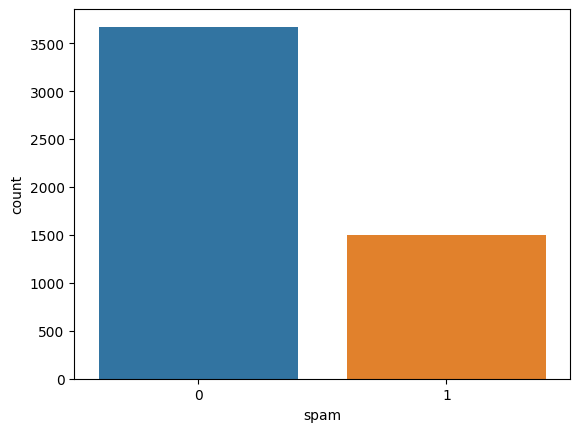

In [40]:
# plot the counts of labels
sns.countplot(data = data, x = 'spam')
plt.show()

The dataset seems unbalanced as a number of not spam emails is twice as much as a number of spam emails

Text(0.5, 0, 'Message types')

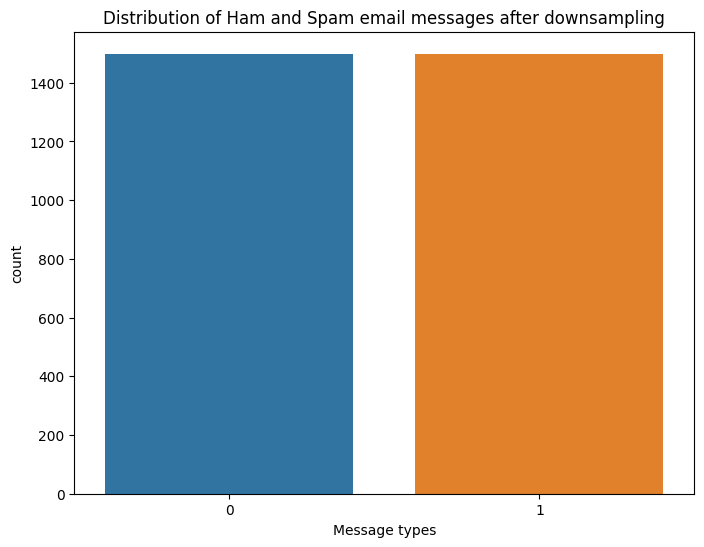

In [41]:
# downsample to balance the data
#by lower sample size of ham messages to be equal to spam messages
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]

ham_msg = ham_msg.sample(n=len(spam_msg), random_state = 42)

balanced_data = ham_msg.append(spam_msg).reset_index(drop = True)

# plot the counts of down sampled dataset
plt.figure(figsize = (8, 6))
sns.countplot(data = balanced_data, x = 'spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

**Text Preprocessing**

In [42]:
# remove the word 'Subject' as it has no use for detecting spam
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')

balanced_data.head()

,text,spam
0,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,: feb 01 prod : sale to teco gas processing\r\...,0
2,": california energy crisis\r\ncalifornia  , s...",0
3,: re : nom / actual volume for april 23 rd\r\n...,0
4,: eastrans nomination changes effective 8 / 2 ...,0


In [43]:
# define a function for removing punctuations
punctuations_list = string.punctuation

def remove_punctuations(text):
  temp = str.maketrans(' ', ' ', punctuations_list) #crate a mapping table to replace ' ' with ' ' and remove punctuations_list
  return text.translate(temp).replace("\r\n"," ")

# apply the function to column 'text' in the dataset
balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,spam
0,conoco big cowboy darren i m not sure if y...,0
1,feb 01 prod sale to teco gas processing sale...,0
2,california energy crisis california  s powe...,0
3,re nom actual volume for april 23 rd we agr...,0
4,eastrans nomination changes effective 8 2 0...,0


In [44]:
# define a function to remove stopwords
def remove_stopwords(text):
  stop_words = stopwords.words('english')

  imp_words = [] # create a list to store important words

  # remove stop words from text store the important words
  for word in str(text).split():
    word = word.lower() # lowercase all words in text

    if word not in stop_words:
      imp_words.append(word)

  output = " ".join(imp_words)

  return output

# apply the function to column 'text' in the dataset
balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_stopwords(x))
balanced_data.head()

,text,spam
0,conoco big cowboy darren sure help know else a...,0
1,feb 01 prod sale teco gas processing sale deal...,0
2,california energy crisis california  power cr...,0
3,nom actual volume april 23 rd agree eileen pon...,0
4,eastrans nomination changes effective 8 2 00 p...,0


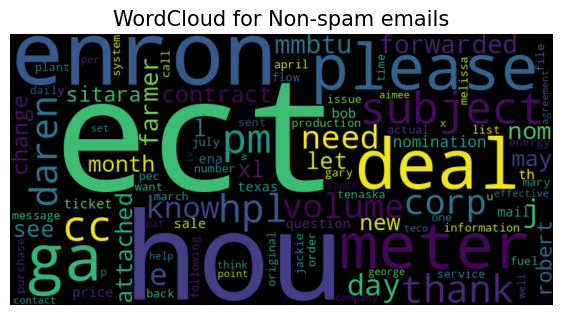

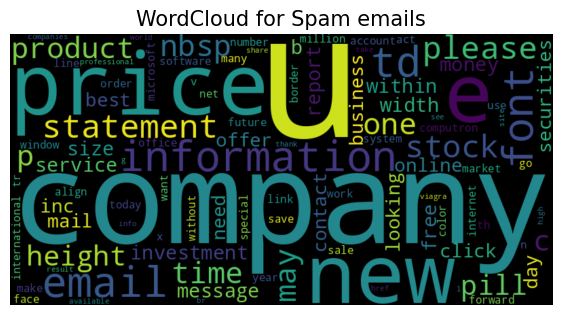

In [46]:
# define a function to plot word cloud
# to get insights into the most frequent words
# most frequent words should not be stopwords
def plot_word_cloud(data, typ):
  email_corpus = " ".join(data['text'])

  plt.figure(figsize = (7, 7))

  wc = WordCloud(background_color = 'black',
                 max_words = 100,
                 width = 800,
                 height = 400,
                 collocations = False).generate(email_corpus) # whether to include collocations (bigrams) of two words

  plt.imshow(wc, interpolation = 'bilinear')
  plt.title(f'WordCloud for {typ} emails', fontsize = 15)
  plt.axis('off')
  plt.show()

# plot the wordclouds for both spam and non-spam text
plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ = 'Non-spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ = 'Spam')

**Convert text to vectors for model training and prediction**

In [47]:
# split data for training and testing
x_train, x_test, y_train, y_test = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [49]:
# tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# convert text to sequences
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# pad sequences to have the same length
max_len = 100

train_sequences = pad_sequences(train_sequences,
                                maxlen = max_len,
                                padding = 'post', # pad after each sequence
                                truncating = 'post') #remove values from sequences larger than maxlen, at the end of the sequences
test_sequences = pad_sequences(test_sequences,
                                maxlen = max_len,
                                padding = 'post',
                                truncating = 'post')

In [51]:
# building a sequential model using tensorflow
model = tf.keras.models.Sequential()

# add three Embedding Layers to learn featured vector representations of the input vectors
model.add(tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index) + 1,
                                    output_dim = 32,
                                    input_length = max_len))

# an LSTM layer to identify useful patterns in the sequence
model.add(tf.keras.layers.LSTM(16))

# use dense layer (fullt connected)
model.add(tf.keras.layers.Dense(32, activation = 'relu'))

# the final layer is the output layer which outputs probabilities for the two classes
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

# print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1274912   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1278625 (4.88 MB)
Trainable params: 1278625 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
# complie a model with three essential parameters
# optimizer: adam
# loss function: binarycrossentropy
# metrics: accuracy
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

**Callback**

Callbacks are used to check whether the model is improving with each epoch or not. If not then what are the necessary steps to be taken like **ReduceLROnPlateau** decreases the learning rate further? Even then if model performance is not improving then training will be stopped by **EarlyStopping**. We can also define some custom callbacks to stop training in between if the desired results have been obtained early.

In [55]:
# EarlyStopping
es = EarlyStopping(patience = 3, # Number of epochs with no improvement after which training will be stopped
                   monitor = 'val_accuracy', # quantity to be monitored
                   restore_best_weights = True) # restore model weights from the epoch with the best value of the monitored quantity

# ReduceLROnPlateau
lr = ReduceLROnPlateau(patience = 2, # number of epochs with no improvement after which learning rate will be reduced
                       monitor = 'val_loss', # quantity to be monitored
                       factor = 0.5, # factor by which the learning rate will be reduced
                       verbose = 0) # messages, 0: quiet

In [56]:
# train the model
history = model.fit(train_sequences, y_train,
                    validation_data = (test_sequences, y_test),
                    epochs = 20,
                    batch_size = 32,
                    callbacks = [lr, es])

Epoch 1/20
75/75 [==============================] - 10s 85ms/step - loss: 0.6861 - accuracy: 0.5655 - val_loss: 0.6093 - val_accuracy: 0.7950 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 5s 63ms/step - loss: 0.3868 - accuracy: 0.8666 - val_loss: 0.3456 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 6s 77ms/step - loss: 0.2525 - accuracy: 0.9254 - val_loss: 0.2992 - val_accuracy: 0.9017 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 5s 61ms/step - loss: 0.2177 - accuracy: 0.9345 - val_loss: 0.3019 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 5s 64ms/step - loss: 0.1918 - accuracy: 0.9420 - val_loss: 0.3037 - val_accuracy: 0.9017 - lr: 0.0010
Epoch 6/20
75/75 [==============================] - 6s 75ms/step - loss: 0.1815 - accuracy: 0.9470 - val_loss: 0.2971 - val_accuracy: 0.9050 - lr: 5.0000e-04
Epoch 7/20
75/75 [==============================] - 5s 64ms/step - loss

In [57]:
# evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, y_test)

print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_accuracy)

19/19 [==============================] - 0s 17ms/step - loss: 0.2954 - accuracy: 0.9067
Test Loss:  0.2954384982585907
Test Accuracy:  0.9066666960716248


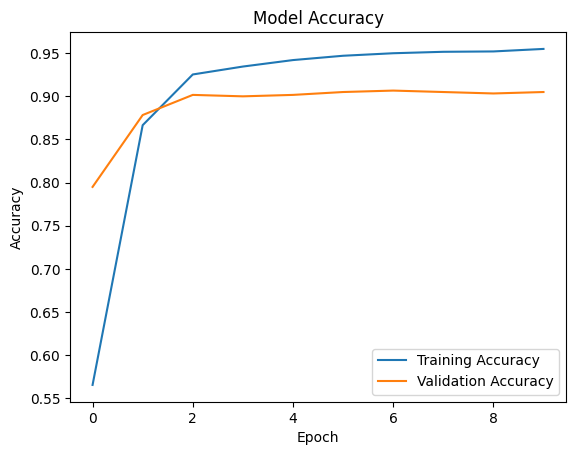

In [58]:
# plot the model evaluation results
# how model accuracy improving after each epoch
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [59]:
model.predict(test_sequences[:9])

1/1 [==============================] - 2s 2s/step


array([[0.0911286 ],
       [0.08860081],
       [0.09112863],
       [0.09112873],
       [0.08533788],
       [0.09112861],
       [0.9950315 ],
       [0.09112867],
       [0.9950761 ]], dtype=float32)

In [64]:
y_test[:9]

1376    0
932     0
144     0
1752    1
51      0
414     0
2529    1
266     0
2704    1
Name: spam, dtype: int64